In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq espiownage fastai wwf # upgrade fastai on colab

# Segmentation Regression - Real data

In [2]:
#all_slow

# Libraries

In [3]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [4]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish   # MishJIT gives me trouble :-( 
from fastai.losses import BaseLoss, MSELossFlat, CrossEntropyLossFlat, BCEWithLogitsLossFlat
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np
import random

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import glob

In [5]:
# system info
import torch, re 
tv, cv = torch.__version__, torch.version.cuda
tv = re.sub('\+cu.*','',tv)
TORCH_VERSION = 'torch'+tv[0:-1]+'0'
CUDA_VERSION = 'cu'+cv.replace('.','')

print(f"TORCH_VERSION={TORCH_VERSION}; CUDA_VERSION={CUDA_VERSION}")
print(f"CUDA available = {torch.cuda.is_available()}, Device count = {torch.cuda.device_count()}, Current device = {torch.cuda.current_device()}")
print(f"Device name = {torch.cuda.get_device_name()}")
print("hostname:")
!hostname

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu111
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 3080
hostname:
bengio


## Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [6]:
#path = untar_data(URLs.CAMVID)
path = Path('/home/shawley/datasets/espiownage-cleaner/')  # real data is local and private 

We can generate masks dynamically using `espiownage`'s `gen_masks` script:

In [125]:
# bin_size = 1 worked ok. But 0.2 and 0.5 yielded nothing; the model couldn't learn at all
bin_size = 0.7  
maskdir = path / ('masks_'+str(bin_size))
!gen_masks --quiet --step={bin_size} --maskdir={maskdir} --files={str(path/'annotations')+'/*.csv'}

usage: gen_masks [-h] [--allone] [--cp_ann_imgs] [--files FILES]
                 [--maskdir MASKDIR] [--step STEP]
gen_masks: error: unrecognized arguments: --quiet


In [8]:
path_im = path/'images'
path_lbl = path/maskdir
 
meta_names = sorted(glob.glob(str(path/'annotations')+'/*.csv'))
fnames = [meta_to_img_path(x, img_bank=path_im) for x in meta_names]
random.shuffle(fnames)
lbl_names = get_image_files(path_lbl)

In [9]:
#sanity check:
len(meta_names), len(fnames), len(lbl_names)

(1955, 1955, 1955)

<AxesSubplot:>

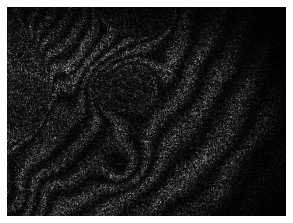

In [10]:
img_fn = fnames[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [11]:
get_msk = lambda o: path/maskdir/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

The segmentation masks are not floating point values, rather they're integers obtained by "binning" the ring counts by bin_size, then generating integers as int(ring_count/bin_size). 

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

<AxesSubplot:>

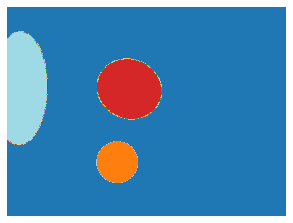

In [12]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [13]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [14]:
set(np.array(msk).flatten())

{0, 2, 5, 16}

the "colors" are the integer values of the quantized ring counts (rescaled by the bin_size)

In [15]:
colors = list(range(int(11/bin_size) + 1))
colors

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

....and because this is based on a classification model, there are text label "codes" (e.g. "dog", "cat") which for us are just the bin-integer mask values, all over again:

In [16]:

codes = [str(n) for n in range(len(colors))]; codes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [17]:
yrange = len(codes); yrange

16

## Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [18]:
sz = msk.shape; sz

(384, 512)

In [19]:
half = tuple(int(x/2) for x in sz); half

(192, 256)

In [20]:
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_msk,
    batch_tfms=[*aug_transforms(size=half, flip_vert=True), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(path/'images', fnames=fnames, bs=4)

/home/shawley/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/shawley/.local/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.li

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

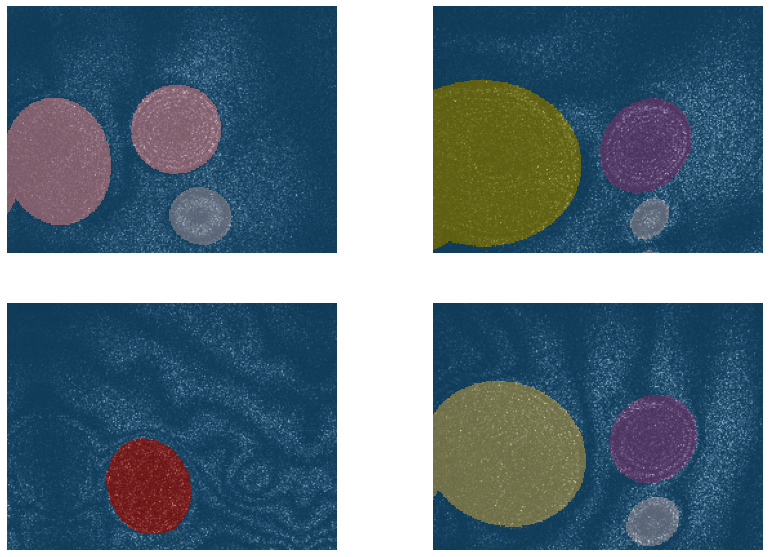

In [21]:
dls.show_batch(max_n=4, vmin=1, vmax=len(codes), figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [22]:
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15}

In [23]:
void_code = name2id['0']

In [24]:
# regression accuracy
def sr_acc_old(inp, targ):          # scores both voids and objects
    targ = targ.squeeze(1)
    return 1 - (inp-targ).abs().round().clamp(max=1).mean() 

def sr_acc(inp, targ, bin_size=1):
    "segmentation regression accuracy: Are we within +/- bin_size?  tries to score only objects, not voids"
    targ = targ.squeeze(1)  
    inp,targ = flatten_check(inp,targ) # https://docs.fast.ai/metrics.html#flatten_check
    mask = targ != void_code  # non_voids
    if len(targ[mask]) == 0:  # Empty image (all void)
        where_correct = (inp-targ).abs() < bin_size              # gonna be ~100%!
    else:
        where_correct = (inp[mask]-targ[mask]).abs() < bin_size  # don't count voids in metric
    return where_correct.float().mean()

# Cell
def sr_acc05(inp, targ): return sr_acc(inp, targ, bin_size=0.5)

# Cell
def sr_acc1(inp, targ): return sr_acc(inp, targ, bin_size=1)

# Cell
def sr_acc15(inp, targ): return sr_acc(inp, targ, bin_size=1.5)

# Cell
def sr_acc2(inp, targ): return sr_acc(inp, targ, bin_size=2)

In [25]:
opt = ranger

# UNet_learner
We turn the classifier into a regression model by specifying on output "class" and then scaling the sigmoid/softmas to the range of values we want..

In [26]:
hrfac = 1.2  # 'headroom factor'
y_range=(0,int(len(codes)*hrfac))  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlineari

In [27]:
#learn = unet_learner(dls, resnet34, yrange=len(codes), loss_func=MSELossFlat(), metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)
metrics = [mae, sr_acc_old, sr_acc05, sr_acc1, sr_acc15, sr_acc2]
learn = unet_learner(dls, resnet34, n_out=1, y_range=y_range, loss_func=MSELossFlat(), metrics=metrics, self_attention=True, act_cls=Mish, opt_func=opt)

/home/shawley/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Suggested Learning Rate = 0.0010000000474974513


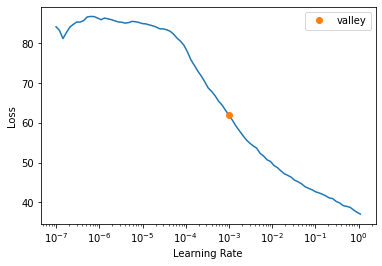

In [28]:
lr = learn.lr_find().valley
print("Suggested Learning Rate =",lr)

In [29]:
lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [30]:
learn.fit_flat_cos(12, slice(lr))  # these frozen epochs don't yield much improvement btw

epoch,train_loss,valid_loss,mae,sr_acc_old,sr_acc05,sr_acc1,sr_acc15,sr_acc2,time
0,6.452745,6.148359,1.113670,0.612370,0.122642,0.285044,0.391644,0.478102,00:29
1,5.727316,5.463809,1.066704,0.636648,0.111263,0.275552,0.363377,0.453009,00:28
2,5.181719,5.475388,0.987454,0.632414,0.152407,0.336251,0.459939,0.574672,00:28
3,5.200410,5.220169,0.960671,0.656919,0.118580,0.272608,0.381213,0.465375,00:28
4,5.094205,5.473570,0.976497,0.649877,0.158929,0.333359,0.463489,0.582000,00:28
5,4.563467,5.130667,0.941906,0.641401,0.171038,0.338715,0.440119,0.548363,00:29
6,4.906682,4.967251,0.898359,0.673602,0.139089,0.303947,0.397863,0.476835,00:28
7,4.377019,4.957646,0.938193,0.642805,0.153293,0.340738,0.449355,0.528070,00:28
8,4.815436,4.916560,0.886570,0.674866,0.123972,0.326800,0.421633,0.506485,00:28
9,4.593746,4.764917,0.882804,0.662049,0.179368,0.356135,0.454269,0.534873,00:28


In [31]:
learn.save('seg_reg_real_1')   
learn.load('seg_reg_real_1')

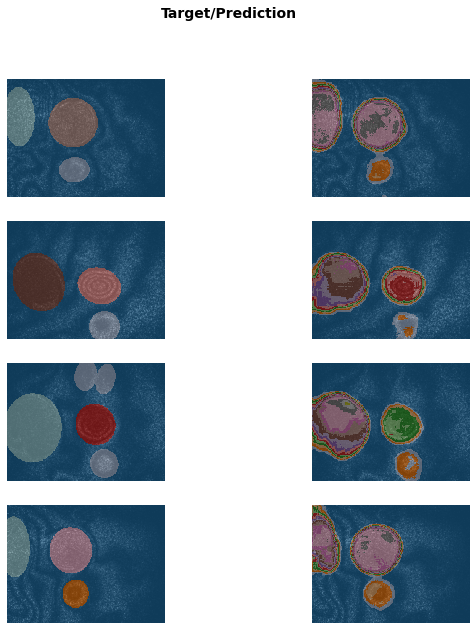

In [32]:
learn.show_results(max_n=6, figsize=(10,10))

^^ if the right column above is all blue, that's bad. but let's unfreeze and see if the model can learn..

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [33]:
lrs = slice(lr/400, lr/4)

In [34]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [35]:
learn.unfreeze()

And train for a bit more

In [36]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,mae,sr_acc_old,sr_acc05,sr_acc1,sr_acc15,sr_acc2,time
0,3.995734,4.524647,0.840972,0.669105,0.187111,0.361301,0.461063,0.539440,00:31
1,4.166564,4.631262,0.865624,0.664963,0.177706,0.357318,0.456896,0.534980,00:31
2,4.150212,4.518520,0.854629,0.662655,0.178328,0.364769,0.470152,0.546210,00:31
3,4.351942,4.497198,0.860823,0.660251,0.182106,0.362297,0.464526,0.542346,00:31
4,3.915153,4.515701,0.858730,0.655916,0.195377,0.367521,0.486544,0.610550,00:31
5,4.202880,4.433903,0.845866,0.663169,0.195712,0.365879,0.468995,0.547106,00:31
6,3.906826,4.401491,0.833205,0.661850,0.196957,0.372214,0.478381,0.564711,00:31
7,3.726359,4.269407,0.794594,0.678205,0.193591,0.362144,0.460162,0.546380,00:31
8,4.039874,4.050292,0.785031,0.672703,0.195462,0.367057,0.470508,0.576974,00:31
9,4.172595,4.151126,0.772815,0.684998,0.176083,0.349598,0.444586,0.538361,00:31


In [37]:
learn.save('seg_reg_real_2')

Path('models/seg_reg_real_2.pth')

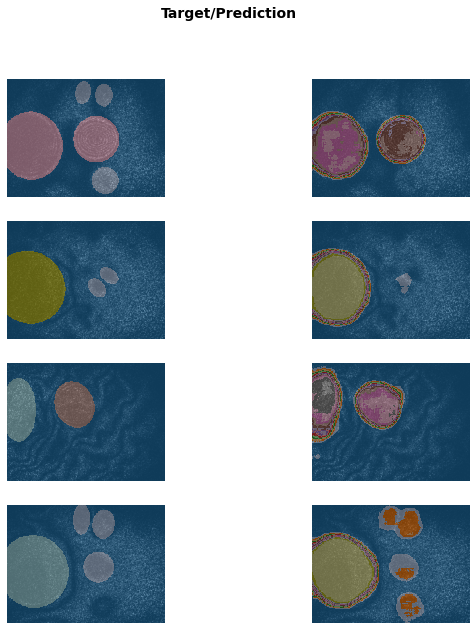

In [38]:
learn.show_results(max_n=6, figsize=(10,10))

## Inference

Let's take a look at how to do inference with `test_dl`

In [39]:
dl = learn.dls.test_dl(fnames[:5]) 

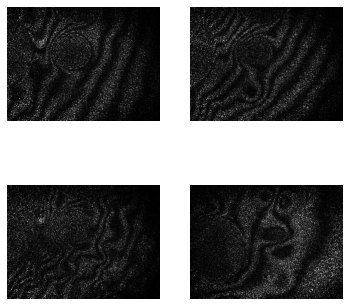

In [40]:
dl.show_batch()

Let's do the first five pictures

In [41]:
preds = learn.get_preds(dl=dl)

In [42]:
preds[0].shape

torch.Size([5, 1, 192, 256])

In [43]:
pred_1 = preds[0][0].squeeze()
pred_1.shape

torch.Size([192, 256])

<AxesSubplot:>

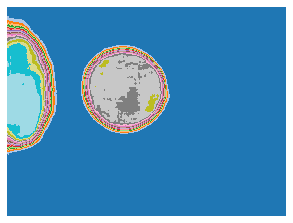

In [44]:
msk = PILMask.create(pred_1)
msk.show(figsize=(5,5), alpha=1)

In [45]:
pred_arx = pred_1.numpy()

In [89]:
# note that we don't want just local image max, global max for the dataset
use_min, use_max = 0, np.max(np.array(colors)) # pred_arx.max(), pred_arx.min()

In [92]:
im.save('seg_reg_real_test.png')

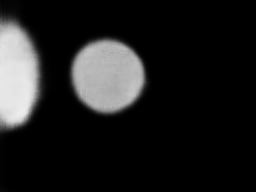

In [93]:
def save_tmask(tmask, fname=''): # save tensor mask
    tmask_new = tmask[0].squeeze().cpu().numpy() 
    rescaled = (255.0 / use_max * (tmask_new - use_min)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    if fname != '': im.save(fname)
    return im

im = save_tmask(preds[0])
im

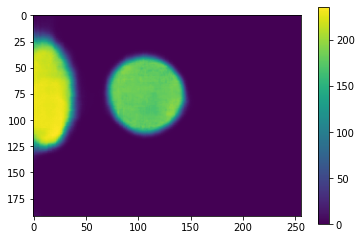

In [94]:
# or in false color, using image values
plt.imshow(im)
plt.colorbar()

Here we have actual ring values:


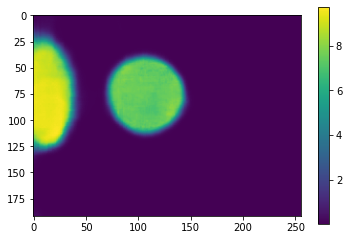

In [95]:
plt.imshow(pred_arx*bin_size)
plt.colorbar()

Actually that's not too bad! 

## Full Size

In [108]:
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_msk,
    batch_tfms=[*aug_transforms(size=sz, flip_vert=True), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(path/'images', fnames=fnames, bs=2)  # smaller batch size because we're now full size
dls.vocab = codes

In [109]:
learn = unet_learner(dls, resnet34, n_out=1, y_range=y_range, loss_func=MSELossFlat(), metrics=metrics, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('seg_reg_real_2')

SuggestedLRs(valley=0.0003343701537232846)

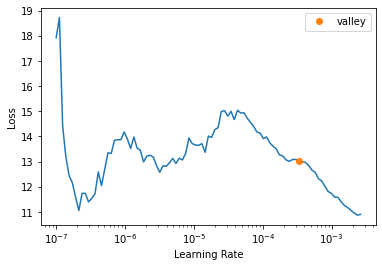

In [110]:
learn.lr_find(end_lr=5e-3)

In [111]:
lr = 3e-4

In [112]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,mae,sr_acc_old,sr_acc05,sr_acc1,sr_acc15,sr_acc2,time
0,5.122582,5.623581,0.971103,0.666941,0.138312,0.330300,0.436181,0.524941,01:30
1,4.794317,5.408369,0.904870,0.684410,0.137275,0.337154,0.444604,0.531549,01:31
2,4.147307,5.061476,0.884276,0.684806,0.139806,0.348756,0.461516,0.549601,01:30
3,4.459257,4.730074,0.845479,0.694127,0.171813,0.355767,0.457810,0.548824,01:31
4,4.584371,5.234722,0.898161,0.682793,0.188356,0.365548,0.462796,0.559584,01:31
5,4.328424,5.183136,0.866989,0.689333,0.172747,0.345528,0.447776,0.566170,01:31
6,4.199661,4.359870,0.798685,0.698975,0.169163,0.353831,0.457196,0.575290,01:30
7,4.277748,4.663462,0.804412,0.704988,0.177788,0.353250,0.453468,0.594752,01:31
8,3.776781,4.697923,0.815755,0.696266,0.186029,0.355152,0.457595,0.609561,01:30
9,4.099283,4.652341,0.798339,0.700152,0.189573,0.363395,0.470341,0.624966,01:31


In [113]:
learn.save('seg_reg_full_real_1')

Path('models/seg_reg_full_real_1.pth')

In [114]:
learn.load('seg_reg_full_real_1')

In [115]:
learn.unfreeze()

In [116]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 2.9999999999999997e-05, None)

In [117]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,mae,sr_acc_old,sr_acc05,sr_acc1,sr_acc15,sr_acc2,time
0,3.600232,4.682748,0.804639,0.700787,0.189581,0.354079,0.462858,0.622944,01:37
1,3.653200,4.308917,0.763131,0.704533,0.190458,0.366450,0.477451,0.620737,01:37
2,3.825050,4.422572,0.788949,0.698985,0.186304,0.363572,0.480243,0.621403,01:37
3,3.171586,4.162901,0.751615,0.708045,0.185853,0.360663,0.482509,0.636361,01:37
4,3.475597,4.062891,0.739716,0.706911,0.187054,0.369136,0.496767,0.636887,01:37
5,3.366224,4.100869,0.736191,0.709015,0.189023,0.368738,0.493945,0.647353,01:37
6,3.584972,4.151577,0.744351,0.707811,0.185984,0.363101,0.490911,0.632922,01:38
7,3.668310,4.086571,0.748119,0.702408,0.193613,0.382688,0.515693,0.651044,01:37
8,3.386723,3.958637,0.728336,0.706896,0.197856,0.384666,0.512204,0.643812,01:38
9,3.343465,3.974596,0.726579,0.709131,0.191052,0.377159,0.505982,0.639345,01:37


In [118]:
learn.save('seg_reg_full_real_2')

Path('models/seg_reg_full_real_2.pth')

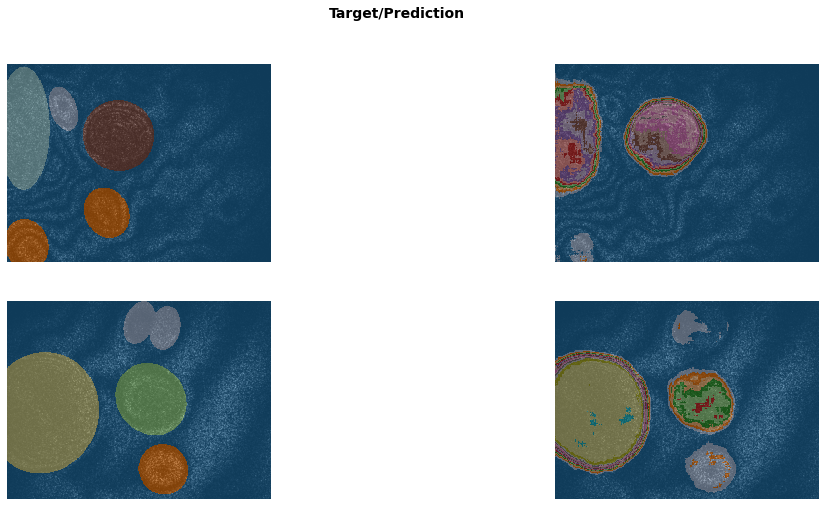

In [119]:
learn.show_results(max_n=10, figsize=(18,8))  # todo: need to show 'soft' version of images

## Inference (Full Size)

In [120]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
print(preds.shape, targs.shape)
len(preds)

torch.Size([391, 1, 384, 512]) torch.Size([391, 384, 512])


391

In [121]:
seg_img_dir = 'seg_reg_images'
!rm -rf {seg_img_dir}; mkdir {seg_img_dir}

In [122]:
results = []
for i in range(len(preds)):
    #line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    filestem = dls.valid.items[i].stem
    line_list = [filestem]+[losses[i].cpu().numpy(), i]
    save_tmask(preds[i], seg_img_dir+'/'+filestem+'_pred.png')
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'loss','i'])

In [123]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.to_csv('segreg_top_losses_real.csv', index=False)

06241902_proc_01642:


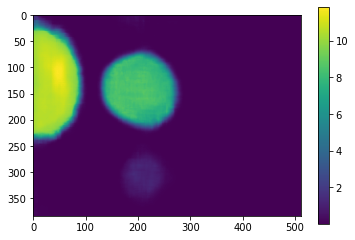

In [128]:
print(dls.valid.items[0].stem+':')
plt.imshow(preds[0][0].cpu().numpy()*bin_size)
plt.colorbar()

06241902_proc_01981: (targ, pred)


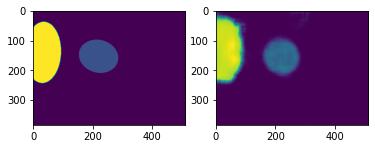

06241902_proc_00979: (targ, pred)


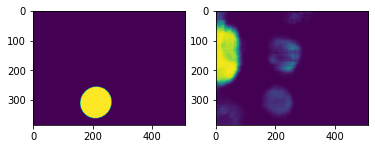

06240907_proc_01510: (targ, pred)


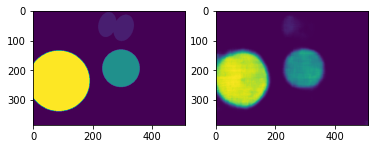

06241902_proc_01769: (targ, pred)


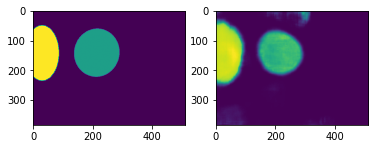

06240907_proc_00614: (targ, pred)


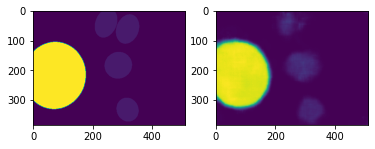

06241902_proc_01728: (targ, pred)


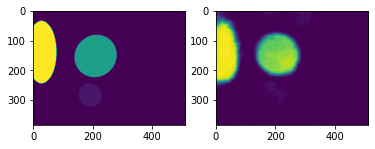

06240907_proc_00307: (targ, pred)


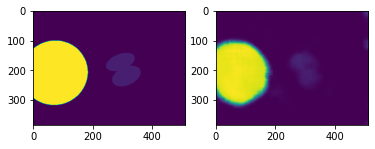

06241902_proc_01017: (targ, pred)


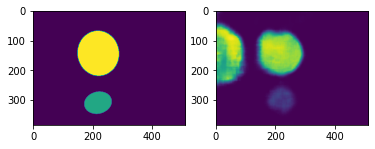

06241902_proc_01802: (targ, pred)


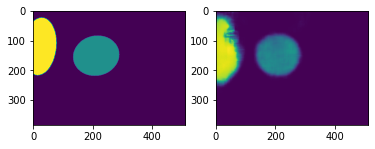

06240907_proc_00553: (targ, pred)


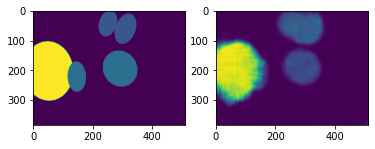

06241902_proc_00621: (targ, pred)


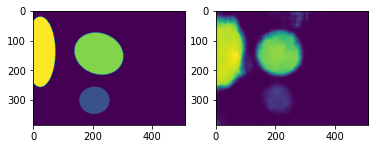

06240907_proc_01940: (targ, pred)


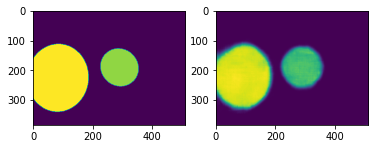

06241902_proc_00482: (targ, pred)


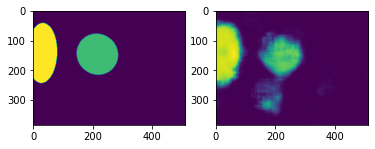

06241902_proc_00455: (targ, pred)


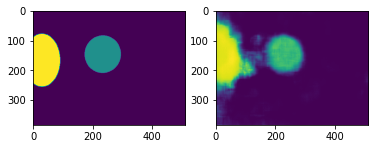

06241902_proc_01994: (targ, pred)


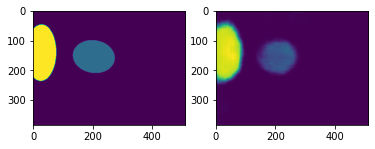

06240907_proc_00909: (targ, pred)


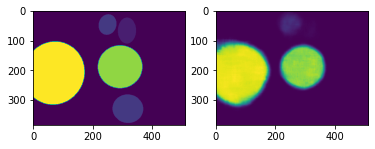

06241902_proc_01284: (targ, pred)


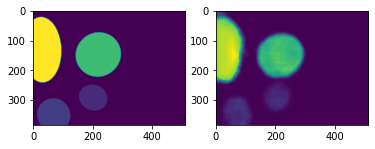

06241902_proc_00623: (targ, pred)


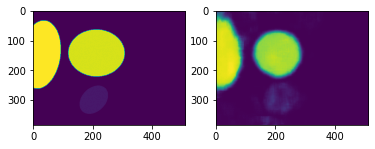

06240907_proc_01248: (targ, pred)


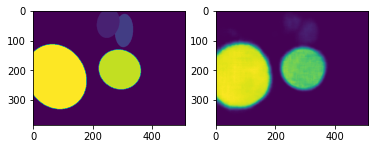

06241902_proc_00780: (targ, pred)


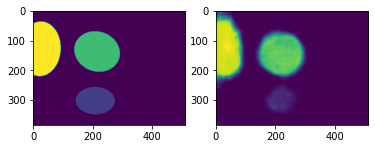

In [146]:
# more plots:
for i in range(20):
    j = i + 200 # move away from zero because I keep seeing the same thing ;-)
    print(dls.valid.items[j].stem+': (targ, pred)')
    fig, axarr = plt.subplots(1,2)
    axarr[0].imshow(targs[j].cpu().numpy()*bin_size)
    axarr[1].imshow(preds[j][0].cpu().numpy()*bin_size)
    plt.show()